[INFO] loading images...
[INFO] processed 500/6615
[INFO] processed 1000/6615
[INFO] processed 1500/6615
[INFO] processed 2000/6615
[INFO] processed 2500/6615
[INFO] processed 3000/6615
[INFO] processed 3500/6615
[INFO] processed 4000/6615
[INFO] processed 4500/6615
[INFO] processed 5000/6615
[INFO] processed 5500/6615
[INFO] processed 6000/6615
[INFO] processed 6500/6615
[INFO] compiling model...
[INFO] training network...
Epoch 1/40
155/155 [==============================] - 257s 2s/step - loss: 2.2413 - accuracy: 0.3165 - val_loss: 2.5134 - val_accuracy: 0.2678
Epoch 2/40
155/155 [==============================] - 260s 2s/step - loss: 1.4289 - accuracy: 0.4510 - val_loss: 2.4168 - val_accuracy: 0.2944
Epoch 3/40
155/155 [==============================] - 258s 2s/step - loss: 1.2482 - accuracy: 0.5046 - val_loss: 3.9342 - val_accuracy: 0.1669
Epoch 4/40
155/155 [==============================] - 260s 2s/step - loss: 1.1592 - accuracy: 0.5372 - val_loss: 2.4273 - val_accuracy: 0.2642


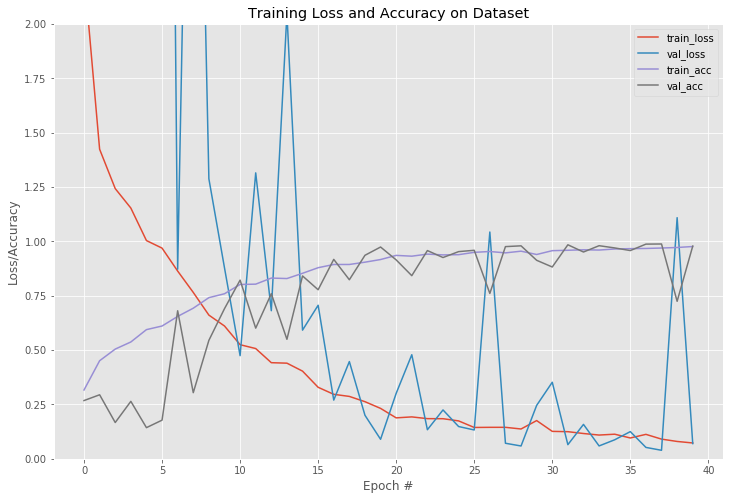

In [1]:
# USAGE
# python minivggnet_flowers17_data_aug.py --dataset ../datasets/flowers17/images

# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from pyimagesearch.preprocessing import ImageToArrayPreprocessor
from pyimagesearch.preprocessing import AspectAwarePreprocessor
from pyimagesearch.datasets import SimpleDatasetLoader
from pyimagesearch.nn.conv import MiniVGGNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
from imutils import paths
import pandas as pd
import numpy as np
import argparse
import os
from datetime import datetime
start_time = datetime.now()
# do your work here


dataset = '../datasets/soda_bottles/images/'
model_output_path = 'git_output/soda/vgg16net_augmentation_soda_notebook.model'
figure_output_path = 'git_output/soda/vgg16net_augmentation_soda_training_plot.png'
csv_output_path = 'git_output/soda/soda_vgg16net_augmentation_notebook_classification_report.csv'
NUM_EPOCHS = 40
DIMS = (124, 124)

# grab the list of images that we'll be describing, then extract
# the class label names from the image paths
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset))
classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths]
classNames = [str(x) for x in np.unique(classNames)]

# initialize the image preprocessors
aap = AspectAwarePreprocessor(DIMS[0], DIMS[1])
iap = ImageToArrayPreprocessor()

# load the dataset from disk then scale the raw pixel intensities
# to the range [0, 1]
sdl = SimpleDatasetLoader(preprocessors=[aap, iap])
(data, labels) = sdl.load(imagePaths, verbose=500)
data = data.astype("float") / 255.0

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.25, random_state=42)

# convert the labels from integers to vectors
trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)

# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=0.05)
model = MiniVGGNet.build(width=DIMS[0], height=DIMS[1], depth=3,
    classes=len(classNames))
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=32),
    validation_data=(testX, testY), steps_per_epoch=len(trainX) // 32,
    epochs=NUM_EPOCHS, verbose=1)

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
    predictions.argmax(axis=1), target_names=classNames))

# output classification report to CSV
report = classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), 
    output_dict=True, target_names=classNames)
df = pd.DataFrame(report).transpose()
df.to_csv(csv_output_path)

# save the network to disk
print("[INFO] serializing network to...{}".format(model_output_path))
model.save(model_output_path)

end_time = datetime.now()
print('*'* 50, '\n[INFO] Duration: {}'.format(end_time - start_time), '\n', '*'*50)

# plot the training loss and accuracy
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(12, 8))
plt.ylim(None, 2)
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.savefig(figure_output_path)
plt.show()

In [ ]:
N